# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200612/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2018/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200814/v1/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200929/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200930/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201001/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Trg/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/'

os.system("mkdir -p "+ plotDir)

0

# Signal part

In [3]:
fpath =OrderedDict()
old_ctaus =OrderedDict()
tree = OrderedDict()
# years = ['Summer16', 'Fall17', 'Fall18']
years = [  'Fall17']
mass = [15, 40, 55]
# mass = [55]
# mass = [15]
# OLD_CTAU = np.array([1000, 10000])#in mm
OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm
# OLD_CTAU = np.array([100])#in mm
# OLD_CTAU = np.array([1000])#in mm
# OLD_CTAU = np.array([10000])#in mm
# OLD_CTAU = np.array([100000])#in mm

# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v13/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v17/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/'
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16/'

for y in years:
        mc_path = home_dir+'/MC_'+y+'/normalized/'
        tune = 'TuneCP5'
        if y == 'Summer16': tune = 'TuneCUETP8M1'
        for m in mass:
                for ct in OLD_CTAU:
                        key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)      
                        fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'   
                        old_ctaus[key] = ct

In [4]:
NEvents = {}
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
#     tree[k] = root_dir['SusyLLPTree']
    tree[k] = root_dir['SusyLLPSigEffTree']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()

MC_Fall17_ggH_15_100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16//MC_Fall17/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-100_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
MC_Fall17_ggH_15_1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16//MC_Fall17/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
MC_Fall17_ggH_15_10000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16//MC_Fall17/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-10000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
MC_Fall17_ggH_15_100000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16//MC_Fall17/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-100000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
MC_Fall17_ggH_40_100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16//MC_Fall17/normalized/ggH

# debug

In [373]:
trg_path=469
# met_cut=0
met_cut=200
#no trg, no met cut


trg_jet_met = {}

trg_jet_w = {} 
trg_jet_puw = {} 



for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()

    hlt = v['HLTDecision'].array()[:,trg_path]


#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    


    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(met>met_cut, met>met_cut)    

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_triggered)
#     met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]

    trg_jet_w[k] = weight[met_trg_str]
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]




    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))


MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f80c4e03550>
(1983000,)
3775
3775
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d12e8358>
(1957000,)
20342
20342
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80d8a405c0>
(2060000,)
29648
29648
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80d3450780>
(1938999,)
28952
28952
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f80d24f6908>
(1954000,)
457
457
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d169fa58>
(1935000,)
10689
10689
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cf44cc50>
(1992999,)
25871
25871
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ce589eb8>
(1997000,)
29763
29763
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f80cd7ffb70>
(2005000,)
221
221
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80cca2a240>
(2036000,)
6660
6660
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cba89390>
(1986999,)
24213
24

In [374]:
# met_cut=0

from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Event Yield', 'Event Yield Error', 'Event Yield [MET > '+str(met_cut)+' GeV]', 'Event Yield Error[MET > '+str(met_cut)+' GeV]', 'SigEff [%]' ])
for k,v in tree.items():

    lumi=137000

    EventALLW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
    EventALLWsq = [x*x  for x in EventALLW]
    EventW = [x*y for x,y in zip(trg_jet_w[k][trg_jet_met[k]>met_cut],trg_jet_puw[k][trg_jet_met[k]>met_cut])]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventALLW)*lumi, 2), round(math.sqrt(np.sum(EventALLWsq))*lumi, 2),round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2), round( 1*(np.sum(EventW)/np.sum(EventALLW)), 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------------+-------------+-------------------+-----------------------------+----------------------------------+------------+
|          Sample         |      Weight     | Event Yield | Event Yield Error | Event Yield [MET > 200 GeV] | Event Yield Error[MET > 200 GeV] | SigEff [%] |
+-------------------------+-----------------+-------------+-------------------+-----------------------------+----------------------------------+------------+
|   MC_Fall17_ggH_15_100  | [1.1407209e-06] |    611.5    |       10.69       |            611.5            |              10.69               |    1.0     |
|  MC_Fall17_ggH_15_1000  | [1.1559251e-06] |    3322.7   |       24.97       |            3322.7           |              24.97               |    1.0     |
|  MC_Fall17_ggH_15_10000 | [1.0982656e-06] |   4609.97   |       28.67       |           4609.97           |              28.67               | 

In [375]:
table_txt = table.get_string()
# with open(plotDir+'/NoTrg_NoMET'+str(met_cut)+'_Eff.txt','w') as file:
# with open(plotDir+'/Trg_NoMET'+str(met_cut)+'_Eff.txt','w') as file:
with open(plotDir+'/NoTrg_MET'+str(met_cut)+'_Eff.txt','w') as file:
# with open(plotDir+'/Trg467_100m_MET'+str(met_cut)+'_Eff.txt','w') as file:
# with open(plotDir+'/Trg467_10m_MET'+str(met_cut)+'_Eff.txt','w') as file:
# with open(plotDir+'/Trg467_1m_MET'+str(met_cut)+'_Eff.txt','w') as file:
# with open(plotDir+'/Trg467_10cm_MET'+str(met_cut)+'_Eff.txt','w') as file:
    file.write(table_txt)

# Reweight check

In [6]:

#no met cut, no trg
# or it defined here
trg_path=467
# met_cut=200
met_cut=0


trg_jet_met = {}

trg_jet_ctau = {}
trg_jet_r = {}
trg_jet_z = {}

trg_jet_w = {} 
trg_jet_puw = {} 



for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()

    hlt = v['HLTDecision'].array()[:,trg_path]


    #gLLP
    llp_ctau = v['gLLP_ctau'].array()
    llp_r = v['gLLP_decay_vertex_r'].array()
    llp_z = v['gLLP_decay_vertex_z'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    


    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '16' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(met>met_cut, met>met_cut)    

#     met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_hlt_triggered)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    trg_jet_r[k] = llp_r[met_trg_str]
    trg_jet_z[k] = llp_z[met_trg_str]
    
    trg_jet_w[k] = weight[met_trg_str]
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]




    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))


MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f8514474d30>
(1983000,)
1946185
1946185
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8504c9ac18>
(1957000,)
1847191
1847191
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f8503f2a3c8>
(2060000,)
2040047
2040047
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84f2f4d898>
(1938999,)
1936106
1936106
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f84f2256e48>
(1954000,)
1951029
1951029
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f84d20922b0>
(1935000,)
1856285
1856285
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f84d1b49748>
(1992999,)
1960366
1960366
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84c1551c50>
(1997000,)
1992369
1992369
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f84b0fdf160>
(2005000,)
2003538
2003538
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8490f13630>
(2036000,)
2003150
2003150
MC_Fall17_ggH_55_10000 <TTree b'SusyL

In [7]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , ' Yield', 'Error'])
for k,v in tree.items():
 
    lumi=137000
 
    EventW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
    EventWsq = [x*x  for x in EventW]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------------+-----------+--------+
|          Sample         |      Weight     |    Yield  | Error  |
+-------------------------+-----------------+-----------+--------+
|   MC_Fall17_ggH_15_100  | [1.1407209e-06] | 317960.29 | 242.94 |
|  MC_Fall17_ggH_15_1000  | [1.1559251e-06] | 305558.38 | 239.73 |
|  MC_Fall17_ggH_15_10000 | [1.0982656e-06] | 321019.31 | 239.54 |
| MC_Fall17_ggH_15_100000 | [1.1667261e-06] |  323775.7 | 247.95 |
|   MC_Fall17_ggH_40_100  | [1.1577148e-06] | 323760.32 | 247.01 |
|  MC_Fall17_ggH_40_1000  | [1.1691003e-06] | 310752.67 | 243.15 |
|  MC_Fall17_ggH_40_10000 | [1.1351731e-06] | 318804.25 | 242.72 |
| MC_Fall17_ggH_40_100000 | [1.1329141e-06] | 323703.45 | 244.33 |
|   MC_Fall17_ggH_55_100  | [1.1282991e-06] | 324166.13 | 244.03 |
|  MC_Fall17_ggH_55_1000  | [1.1111623e-06] | 318917.06 | 240.16 |
|  MC_Fall17_ggH_55_10000 | [1.1385872e-06] | 319781.43 | 243.44

In [378]:
table_txt = table.get_string()
# with open(plotDir+'/NoTrg_10m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/NoTrg_1m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_10m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_1m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_10cm_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_100m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/NoTrg_NoMET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg_NoMET'+str(met_cut)+'_Yield.txt','w') as file:
with open(plotDir+'/NoTrg_MET'+str(met_cut)+'_Yield.txt','w') as file:
    file.write(table_txt)

In [302]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

In [379]:
# OLD_CTAU=10000 #mm
# ctaus=np.array([1000])

# OLD_CTAU=1000 #mm
# OLD_CTAU=10000 #mm
ctaus=np.array([100, 1000, 10000, 100000])
# ctaus=np.array([100])
# ctaus=np.array([1000])
# ctaus=np.array([10000])

EventReW = {}
EventReWsq = {}
for k,v in tree.items():
    print(k)
#     print(k.split('_')[-1])
#     print(len(k.split('_')[-1]))
#     print(type(k.split('_')[-1]))
    old_ctau = float(k.split('_')[-1])
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    EventReWsq[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k]  ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, old_ctau/10) # convert everything to cm
        EventReW[k][ct] =  trg_jet_w[k]*weight_ctau*trg_jet_puw[k] 
        EventReWsq[k][ct] =  [x*x  for x in EventReW[k][ct]]


MC_Fall17_ggH_15_100
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_15_1000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_15_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_15_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_100
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_1000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_100
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_1000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


In [380]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', ' Yield', 'Error'])
for k,v in tree.items():
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReWsq[k][ct]))*lumi,2) ] 
#                round(math.sqrt(np.sum(EventReWsq[k][ct])*lumi), 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------+---------+--------+
|          Sample         | Ctau [mm] |   Yield | Error  |
+-------------------------+-----------+---------+--------+
|   MC_Fall17_ggH_15_100  |    100    |  611.5  | 10.69  |
|   MC_Fall17_ggH_15_100  |    1000   |  943.61 | 282.08 |
|   MC_Fall17_ggH_15_100  |   10000   |  22.65  |  9.14  |
|   MC_Fall17_ggH_15_100  |   100000  |   0.25  |  0.1   |
|  MC_Fall17_ggH_15_1000  |    100    |  665.54 | 39.04  |
|  MC_Fall17_ggH_15_1000  |    1000   |  3322.7 | 24.97  |
|  MC_Fall17_ggH_15_1000  |   10000   | 2554.68 | 865.14 |
|  MC_Fall17_ggH_15_1000  |   100000  |  67.62  | 31.43  |
|  MC_Fall17_ggH_15_10000 |    100    |  884.46 | 323.9  |
|  MC_Fall17_ggH_15_10000 |    1000   | 3450.37 | 118.76 |
|  MC_Fall17_ggH_15_10000 |   10000   | 4609.97 | 28.67  |
|  MC_Fall17_ggH_15_10000 |   100000  | 1656.36 | 168.6  |
| MC_Fall17_ggH_15_100000 |    100    |   1.95  | 

In [381]:
table_txt = table.get_string()
# with open(plotDir+'/NoTrg_NoMET'+str(met_cut)+'_Reweight_Yield.txt','w') as file:
# with open(plotDir+'/Trg_NoMET'+str(met_cut)+'_Reweight_Yield.txt','w') as file:
with open(plotDir+'/NoTrg_MET'+str(met_cut)+'_Reweight_Yield.txt','w') as file:
    file.write(table_txt)

In [365]:
# OLD_CTAU=10000 #mm
# ctaus=np.array([1000])

# OLD_CTAU=1000 #mm
OLD_CTAU=10000 #mm
ctaus=np.array([100, 1000, 10000, 100000])
# ctaus=np.array([100])
# ctaus=np.array([1000])
# ctaus=np.array([10000])

EventReW = {}
EventReWsq = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    EventReWsq[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k] ,trg_jet_puw[k] )]
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k]  ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] =  trg_jet_w[k]*weight_ctau*trg_jet_puw[k] 
        EventReWsq[k][ct] =  [x*x  for x in EventReW[k][ct]]


MC_Fall17_ggH_15_100
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_15_1000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_15_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_15_100000
ctau 100  mm


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in float_scalars


MC_Fall17_ggH_40_100
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_1000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_40_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_100
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_1000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm
MC_Fall17_ggH_55_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


In [269]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', ' Yield', 'Error'])
for k,v in tree.items():
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReWsq[k][ct]))*lumi,2) ] 
#                round(math.sqrt(np.sum(EventReWsq[k][ct])*lumi), 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------+--------+-------+
|          Sample         | Ctau [mm] |  Yield | Error |
+-------------------------+-----------+--------+-------+
| MC_Fall17_ggH_15_100000 |    100    |  nan   |  nan  |
| MC_Fall17_ggH_15_100000 |    1000   |  nan   |  nan  |
| MC_Fall17_ggH_15_100000 |   10000   |  nan   |  nan  |
| MC_Fall17_ggH_15_100000 |   100000  |  inf   |  inf  |
+-------------------------+-----------+--------+-------+


In [270]:
table_txt = table.get_string()
# with open(plotDir+'/NoTrg_10mTo1m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/NoTrg_1mTo10m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_10mTo1m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_1mTo10m_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_1mTo10cm_MET'+str(met_cut)+'_Yield.txt','w') as file:
# with open(plotDir+'/Trg467_10mTo_MET'+str(met_cut)+'_Yield.txt','w') as file:
with open(plotDir+'/Trg467_100mTo_MET'+str(met_cut)+'_Yield.txt','w') as file:
    file.write(table_txt)

# ctau in (r,z)

In [32]:
 


# r1_sel = np.logical_and(trg_jet_r[k][:,0]>50, trg_jet_r[k][:,0]<150) #cm
# r2_sel = np.logical_and(trg_jet_r[k][:,1]>50, trg_jet_r[k][:,1]<150) #cm
# rz1_sel = np.logical_and(r1_sel, abs(trg_jet_z[k][:,0])<100) #cm
# rz2_sel = np.logical_and(r2_sel, abs(trg_jet_z[k][:,1])<100) #cm
# rz12_sel = np.logical_or(rz1_sel, rz1_sel) 

# print(len(trg_jet_ctau[k]))
# print(len(trg_jet_r[k]))
# print(len(trg_jet_ctau[k][rz12_sel]))
# print(len(trg_jet_ctau[k][rz12_sel][0]))
# print(type(trg_jet_ctau[k][rz12_sel]))
# # print(trg_jet_ctau[k][rz12_sel])
# print(trg_jet_ctau[k][rz12_sel][:10])
# print(trg_jet_r[k][rz12_sel][:10])
# print(trg_jet_z[k][rz12_sel][:10])

 

MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f8514474d30>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8504c9ac18>
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f8503f2a3c8>
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84f2f4d898>
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f84f2256e48>
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f84d20922b0>
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f84d1b49748>
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84c1551c50>
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f84b0fdf160>
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8490f13630>
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f847fa89ac8>
MC_Fall17_ggH_55_100000 <TTree b'SusyLLPSigEffTree' at 0x7f846f54cb70>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_tube.png has been created


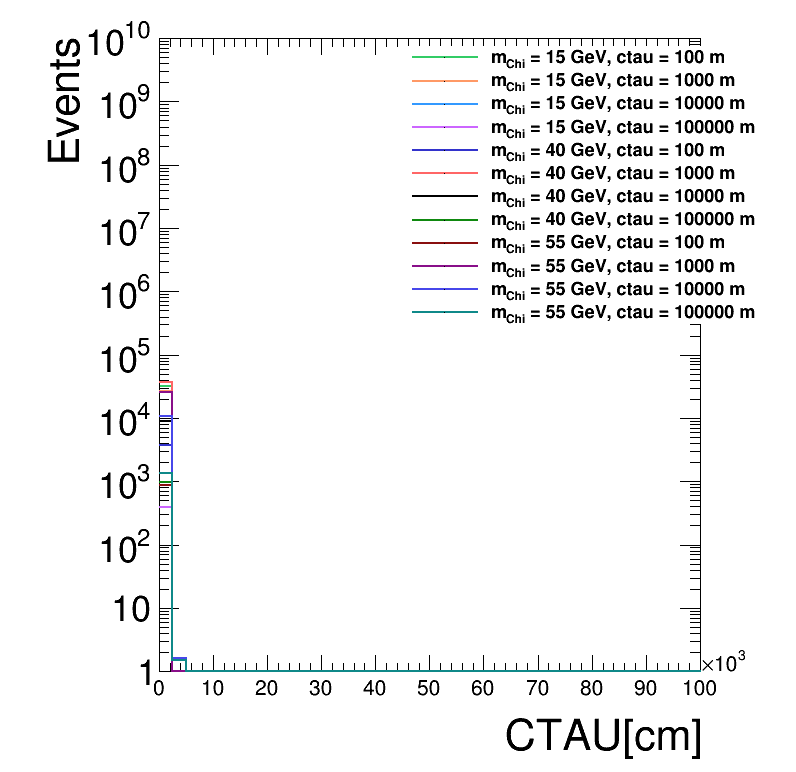

In [34]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
# leg = rt.TLegend(0.60,0.78,0.97,0.94)
leg = rt.TLegend(0.50,0.58,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625, 200,209,205,221,215,225,825]

i=0
for k,v in tree.items():
    print(k,v)
#     print(i)

    
    r1_sel = np.logical_and(trg_jet_r[k][:,0]>50, trg_jet_r[k][:,0]<150) #cm
    r2_sel = np.logical_and(trg_jet_r[k][:,1]>50, trg_jet_r[k][:,1]<150) #cm
    rz1_sel = np.logical_and(r1_sel, abs(trg_jet_z[k][:,0])<100) #cm
    rz2_sel = np.logical_and(r2_sel, abs(trg_jet_z[k][:,1])<100) #cm
    rz12_sel = np.logical_or(rz1_sel, rz1_sel) 
    
    sel_str = rz12_sel
    
    var = trg_jet_ctau[k][sel_str]
    ws = trg_jet_w[k][sel_str]*trg_jet_puw[k][sel_str]
    axis_set = ['CTAU[cm]', 'Events']
    bin_set = [40,0,100000]
#     bin_set = [40,0,1000]
    lumi=137000
    
    ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+10)
#     ht[k].Fit('expo')
#     print(k, std_color_list[i])
    ht[k].Draw("hist same")
    leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV, ctau = '+k.split('_')[-1]+' m')  
    
    i+=1
    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.12)
c.SetLogy()
c.Draw()
outf='CTAU_original_tube.png'
c.SaveAs(plotDir+outf)    
    

MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f8514474d30>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8504c9ac18>
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f8503f2a3c8>
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84f2f4d898>
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f84f2256e48>
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f84d20922b0>
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f84d1b49748>
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84c1551c50>
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f84b0fdf160>
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8490f13630>
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f847fa89ac8>
MC_Fall17_ggH_55_100000 <TTree b'SusyLLPSigEffTree' at 0x7f846f54cb70>
MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f8514474d30>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8504c9ac18>
MC_Fall17_ggH_15_10000 <TTree

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_mass15_tube.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_mass40_tube.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_mass55_tube.png has been created


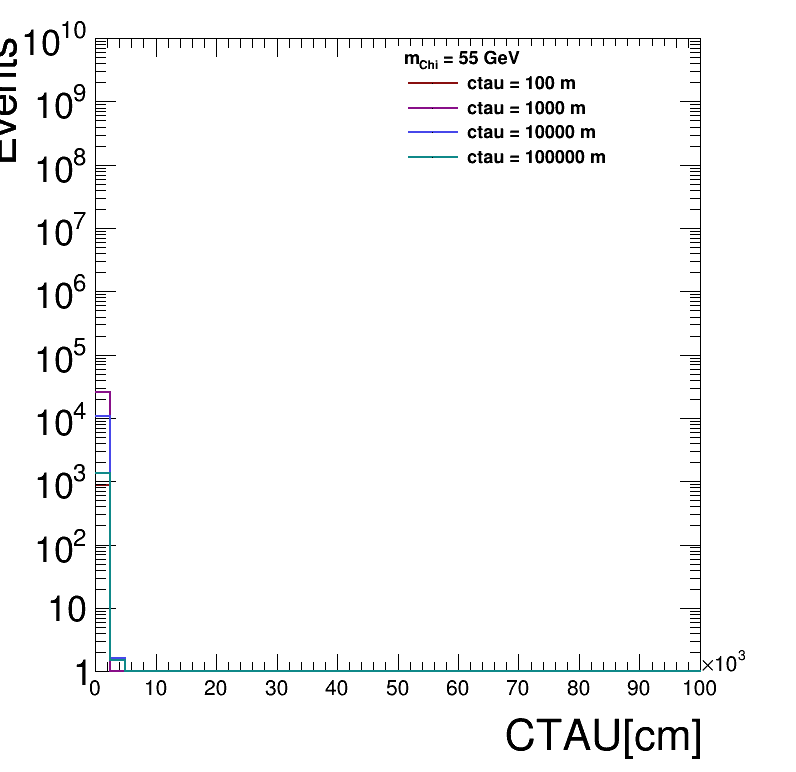

In [35]:
# Plotting 

# mass = [15, 40, 55]
 
# OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

# c = rt.TCanvas('c','c', 800, 800)
# ht = {}
# # leg = rt.TLegend(0.60,0.78,0.97,0.94)
# leg = rt.TLegend(0.50,0.58,0.97,0.94)

# leg.SetTextSize(0.025)
# leg.SetBorderSize(0)
# leg.SetEntrySeparation(0.01)

# i=0
color_list = [845,806,861,876,597,625, 200,209,205,221,215,225,825]



for ms in mass:


    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.50,0.78,0.85,0.94)
#     leg = rt.TLegend(0.50,0.58,0.94,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    i=0
    for k,v in tree.items():
        print(k,v)    
        
        r1_sel = np.logical_and(trg_jet_r[k][:,0]>50, trg_jet_r[k][:,0]<150) #cm
        r2_sel = np.logical_and(trg_jet_r[k][:,1]>50, trg_jet_r[k][:,1]<150) #cm
        rz1_sel = np.logical_and(r1_sel, abs(trg_jet_z[k][:,0])<100) #cm
        rz2_sel = np.logical_and(r2_sel, abs(trg_jet_z[k][:,1])<100) #cm
        rz12_sel = np.logical_or(rz1_sel, rz1_sel) 

        sel_str = rz12_sel

        var = trg_jet_ctau[k][sel_str]
        ws = trg_jet_w[k][sel_str]*trg_jet_puw[k][sel_str]
    
#         var = trg_jet_ctau[k]
#         ws = trg_jet_w[k]*trg_jet_puw[k]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,100000]
    #     bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+10)
    #     ht[k].Fit('expo')
    #     print(k, std_color_list[i])
    
        i+=1
        
        leg.SetHeader('m_{Chi} = '+str(ms)+' GeV')
        if str(ms) in k: 
            ht[k].Draw("hist same")
            leg.AddEntry(ht[k],'ctau = '+k.split('_')[-1]+' m')  
#             leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV, ctau = '+k.split('_')[-1]+' m') 

    leg.Draw()
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.12)
    c.SetLogy()
    c.Draw()
    outf='CTAU_original_mass'+str(ms)+'_tube.png'
    c.SaveAs(plotDir+outf)    

#     i+=1
        

    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

# leg.Draw()
# c.SetLeftMargin(0.12)
# c.SetRightMargin(0.12)
# c.SetLogy()
# c.Draw()
# outf='CTAU_original.png'
# c.SaveAs(plotDir+outf)    
    

MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f8514474d30>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8504c9ac18>
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f8503f2a3c8>
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84f2f4d898>
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f84f2256e48>
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f84d20922b0>
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f84d1b49748>
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f84c1551c50>
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f84b0fdf160>
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8490f13630>
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f847fa89ac8>
MC_Fall17_ggH_55_100000 <TTree b'SusyLLPSigEffTree' at 0x7f846f54cb70>
MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f8514474d30>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f8504c9ac18>
MC_Fall17_ggH_15_10000 <TTree

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_ctau100_tube.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_ctau1000_tube.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_ctau10000_tube.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/CTAU_original_ctau100000_tube.png has been created


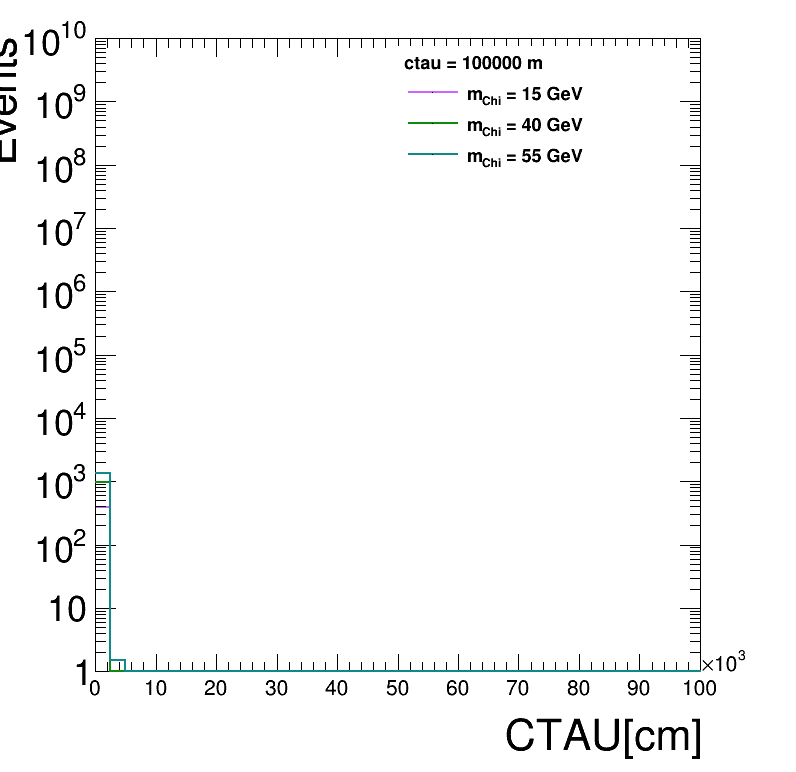

In [36]:
# Plotting 

# mass = [15, 40, 55]
 
OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

# c = rt.TCanvas('c','c', 800, 800)
# ht = {}
# # leg = rt.TLegend(0.60,0.78,0.97,0.94)
# leg = rt.TLegend(0.50,0.58,0.97,0.94)

# leg.SetTextSize(0.025)
# leg.SetBorderSize(0)
# leg.SetEntrySeparation(0.01)

# i=0
color_list = [845,806,861,876,597,625, 200,209,205,221,215,225,825]



for cts in OLD_CTAU:
    
    ct = str(cts)


    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.50,0.78,0.85,0.94)
#     leg = rt.TLegend(0.50,0.58,0.94,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    i=0
    for k,v in tree.items():
        print(k,v)   
        
        r1_sel = np.logical_and(trg_jet_r[k][:,0]>50, trg_jet_r[k][:,0]<150) #cm
        r2_sel = np.logical_and(trg_jet_r[k][:,1]>50, trg_jet_r[k][:,1]<150) #cm
        rz1_sel = np.logical_and(r1_sel, abs(trg_jet_z[k][:,0])<100) #cm
        rz2_sel = np.logical_and(r2_sel, abs(trg_jet_z[k][:,1])<100) #cm
        rz12_sel = np.logical_or(rz1_sel, rz1_sel) 

        sel_str = rz12_sel

        var = trg_jet_ctau[k][sel_str]
        ws = trg_jet_w[k][sel_str]*trg_jet_puw[k][sel_str]
        
#         var = trg_jet_ctau[k]
#         ws = trg_jet_w[k]*trg_jet_puw[k]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,cts]
    #     bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+10)
#         ht[k].Fit('expo')
    #     print(k, std_color_list[i])
    
        i+=1
        
        leg.SetHeader('m_{Chi} = '+str(ms)+' GeV')
        leg.SetHeader('ctau = '+ct+' m')  
#         leg.SetHeader('m_{Chi} = '+str(ms)+' GeV')
        if str(ct)==k.split('_')[-1]: 
            ht[k].Draw("hist same")
            leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV')  
#             leg.AddEntry(ht[k],'ctau = '+k.split('_')[-1]+' m')  
#             leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV, ctau = '+k.split('_')[-1]+' m') 

    leg.Draw()
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.12)
    c.SetLogy()
    c.Draw()
    outf='CTAU_original_ctau'+str(ct)+'_tube.png'
    c.SaveAs(plotDir+outf)    

#     i+=1
        

    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

# leg.Draw()
# c.SetLeftMargin(0.12)
# c.SetRightMargin(0.12)
# c.SetLogy()
# c.Draw()
# outf='CTAU_original.png'
# c.SaveAs(plotDir+outf)    
    

# ctau fit to expo

MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f80c4e03550>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d12e8358>
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80d8a405c0>
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80d3450780>
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f80d24f6908>
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d169fa58>
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cf44cc50>
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ce589eb8>
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f80cd7ffb70>
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80cca2a240>
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cba89390>
MC_Fall17_ggH_55_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ca9bc518>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original.png has been created


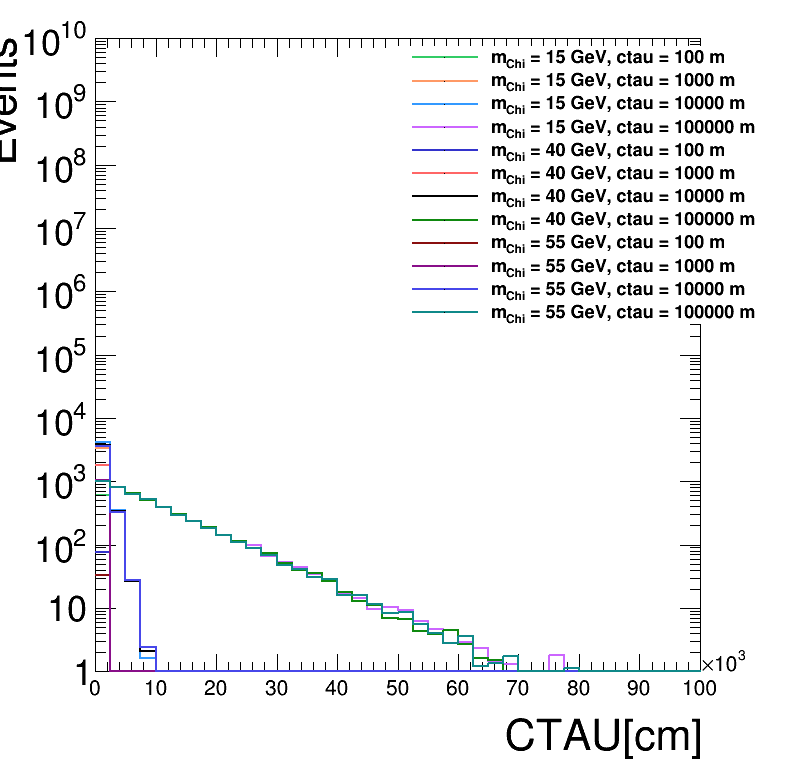

In [382]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
# leg = rt.TLegend(0.60,0.78,0.97,0.94)
leg = rt.TLegend(0.50,0.58,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625, 200,209,205,221,215,225,825]

i=0
for k,v in tree.items():
    print(k,v)
#     print(i)

    
    
    var = trg_jet_ctau[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['CTAU[cm]', 'Events']
    bin_set = [40,0,100000]
#     bin_set = [40,0,1000]
    lumi=137000
    
    ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+10)
#     ht[k].Fit('expo')
#     print(k, std_color_list[i])
    ht[k].Draw("hist same")
    leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV, ctau = '+k.split('_')[-1]+' m')  
    
    i+=1
    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.12)
c.SetRightMargin(0.12)
c.SetLogy()
c.Draw()
outf='CTAU_original.png'
c.SaveAs(plotDir+outf)    
    

MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f80c4e03550>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d12e8358>
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80d8a405c0>
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80d3450780>
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f80d24f6908>
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d169fa58>
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cf44cc50>
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ce589eb8>
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f80cd7ffb70>
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80cca2a240>
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cba89390>
MC_Fall17_ggH_55_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ca9bc518>
MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f80c4e03550>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d12e8358>
MC_Fall17_ggH_15_10000 <TTree

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_mass15.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_mass40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_mass55.png has been created


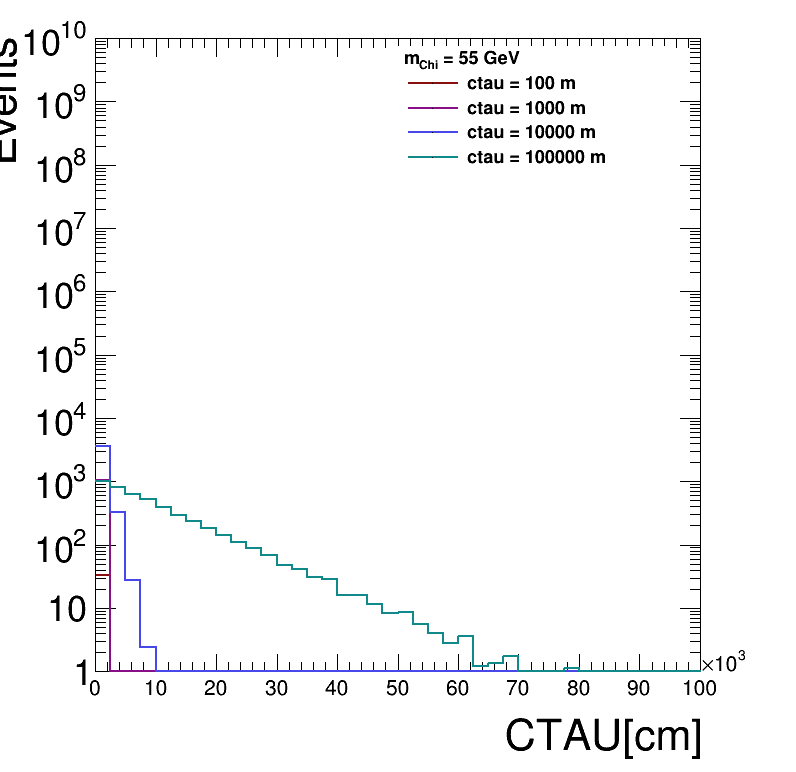

In [383]:
# Plotting 

# mass = [15, 40, 55]
 
# OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

# c = rt.TCanvas('c','c', 800, 800)
# ht = {}
# # leg = rt.TLegend(0.60,0.78,0.97,0.94)
# leg = rt.TLegend(0.50,0.58,0.97,0.94)

# leg.SetTextSize(0.025)
# leg.SetBorderSize(0)
# leg.SetEntrySeparation(0.01)

# i=0
color_list = [845,806,861,876,597,625, 200,209,205,221,215,225,825]



for ms in mass:


    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.50,0.78,0.85,0.94)
#     leg = rt.TLegend(0.50,0.58,0.94,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    i=0
    for k,v in tree.items():
        print(k,v)            
        var = trg_jet_ctau[k]
        ws = trg_jet_w[k]*trg_jet_puw[k]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,100000]
    #     bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+10)
    #     ht[k].Fit('expo')
    #     print(k, std_color_list[i])
    
        i+=1
        
        leg.SetHeader('m_{Chi} = '+str(ms)+' GeV')
        if str(ms) in k: 
            ht[k].Draw("hist same")
            leg.AddEntry(ht[k],'ctau = '+k.split('_')[-1]+' m')  
#             leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV, ctau = '+k.split('_')[-1]+' m') 

    leg.Draw()
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.12)
    c.SetLogy()
    c.Draw()
    outf='CTAU_original_mass'+str(ms)+'.png'
    c.SaveAs(plotDir+outf)    

#     i+=1
        

    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

# leg.Draw()
# c.SetLeftMargin(0.12)
# c.SetRightMargin(0.12)
# c.SetLogy()
# c.Draw()
# outf='CTAU_original.png'
# c.SaveAs(plotDir+outf)    
    

MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f80c4e03550>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d12e8358>
MC_Fall17_ggH_15_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80d8a405c0>
MC_Fall17_ggH_15_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80d3450780>
MC_Fall17_ggH_40_100 <TTree b'SusyLLPSigEffTree' at 0x7f80d24f6908>
MC_Fall17_ggH_40_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d169fa58>
MC_Fall17_ggH_40_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cf44cc50>
MC_Fall17_ggH_40_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ce589eb8>
MC_Fall17_ggH_55_100 <TTree b'SusyLLPSigEffTree' at 0x7f80cd7ffb70>
MC_Fall17_ggH_55_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80cca2a240>
MC_Fall17_ggH_55_10000 <TTree b'SusyLLPSigEffTree' at 0x7f80cba89390>
MC_Fall17_ggH_55_100000 <TTree b'SusyLLPSigEffTree' at 0x7f80ca9bc518>
MC_Fall17_ggH_15_100 <TTree b'SusyLLPSigEffTree' at 0x7f80c4e03550>
MC_Fall17_ggH_15_1000 <TTree b'SusyLLPSigEffTree' at 0x7f80d12e8358>
MC_Fall17_ggH_15_10000 <TTree

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_ctau100.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_ctau1000.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_ctau10000.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201002/Met/CTAU_original_ctau100000.png has been created


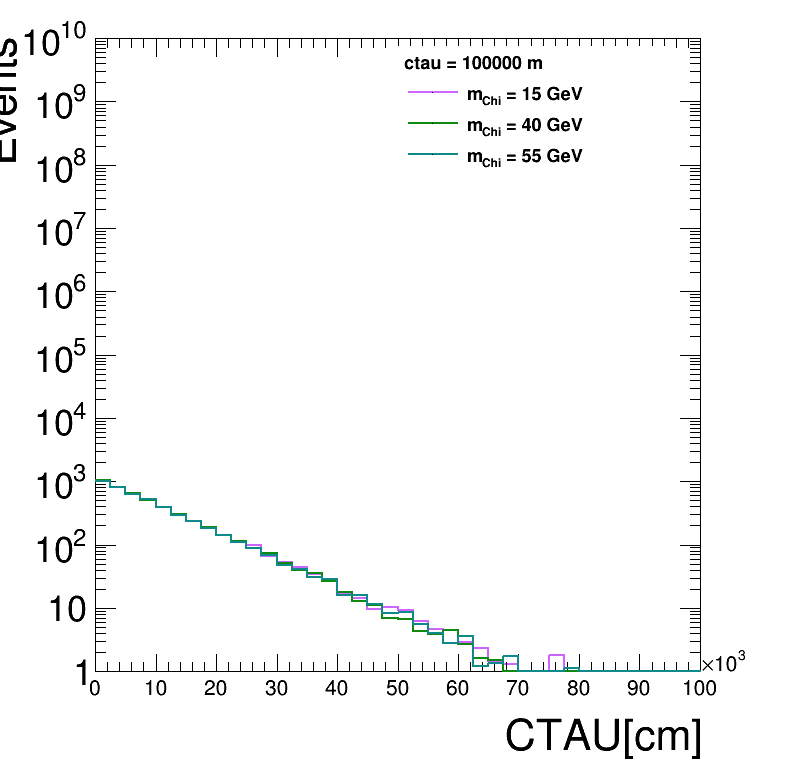

In [385]:
# Plotting 

# mass = [15, 40, 55]
 
OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

# c = rt.TCanvas('c','c', 800, 800)
# ht = {}
# # leg = rt.TLegend(0.60,0.78,0.97,0.94)
# leg = rt.TLegend(0.50,0.58,0.97,0.94)

# leg.SetTextSize(0.025)
# leg.SetBorderSize(0)
# leg.SetEntrySeparation(0.01)

# i=0
color_list = [845,806,861,876,597,625, 200,209,205,221,215,225,825]



for cts in OLD_CTAU:
    
    ct = str(cts)


    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.50,0.78,0.85,0.94)
#     leg = rt.TLegend(0.50,0.58,0.94,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    i=0
    for k,v in tree.items():
        print(k,v)            
        var = trg_jet_ctau[k]
        ws = trg_jet_w[k]*trg_jet_puw[k]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,cts]
    #     bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+10)
#         ht[k].Fit('expo')
    #     print(k, std_color_list[i])
    
        i+=1
        
        leg.SetHeader('m_{Chi} = '+str(ms)+' GeV')
        leg.SetHeader('ctau = '+ct+' m')  
#         leg.SetHeader('m_{Chi} = '+str(ms)+' GeV')
        if str(ct)==k.split('_')[-1]: 
            ht[k].Draw("hist same")
            leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV')  
#             leg.AddEntry(ht[k],'ctau = '+k.split('_')[-1]+' m')  
#             leg.AddEntry(ht[k],'m_{Chi} = '+k.split('_')[-2]+' GeV, ctau = '+k.split('_')[-1]+' m') 

    leg.Draw()
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.12)
    c.SetLogy()
    c.Draw()
    outf='CTAU_original_ctau'+str(ct)+'.png'
    c.SaveAs(plotDir+outf)    

#     i+=1
        

    
# CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
# CMS_lumi.cmsText = ""
# CMS_lumi.writeExtraText = False
# CMS_lumi.CMS_lumi(c,4,3)

# leg.Draw()
# c.SetLeftMargin(0.12)
# c.SetRightMargin(0.12)
# c.SetLogy()
# c.Draw()
# outf='CTAU_original.png'
# c.SaveAs(plotDir+outf)    
    

200 <TTree b'SusyLLPSigEffTree' at 0x7f24e4bce0b8>
200 1
 FCN=112.926 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=1.7408e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.22775e+01   1.58204e-02   6.52172e-05  -3.35955e-03
   2  Slope       -1.01441e-01   1.04887e-04   4.32403e-07   8.47058e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200922/CTAU_reweight.png has been created


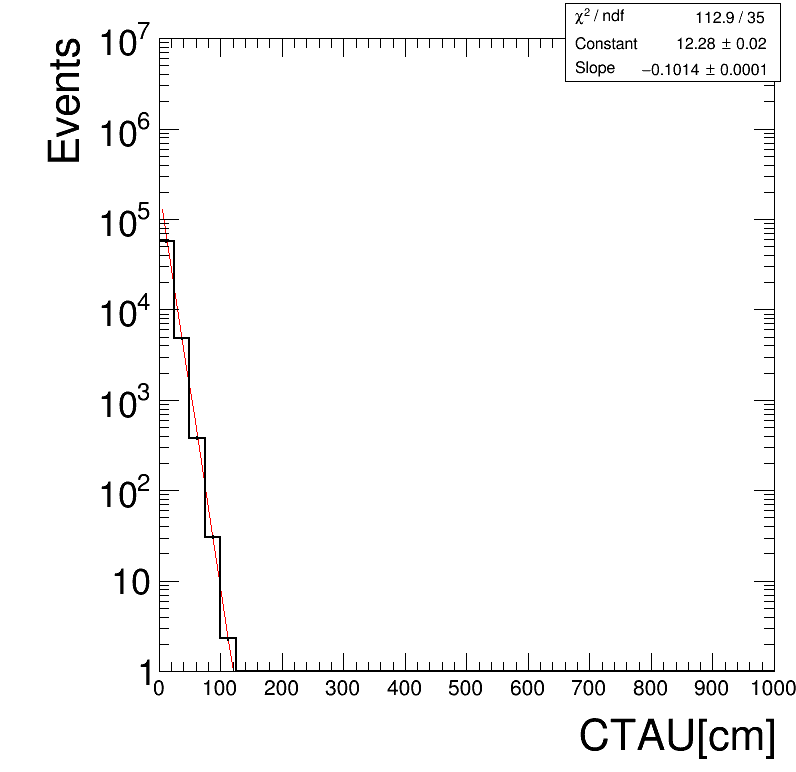

In [31]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    

    var = trg_jet_ctau[k]
    for ct in ctaus:
        ws = EventReW[k][ct]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+7)
        ht[k].Fit('expo')
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

    # CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    # CMS_lumi.cmsText = ""
    # CMS_lumi.writeExtraText = False
    # CMS_lumi.CMS_lumi(c,4,3)

    # leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    outf='CTAU_reweight.png'
    c.SaveAs(plotDir+outf)    


200 <TTree b'SusyLLPSigEffTree' at 0x7f24e4bce0b8>
200 1
200 2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: 200 (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200922/CTAU_com.png has been created


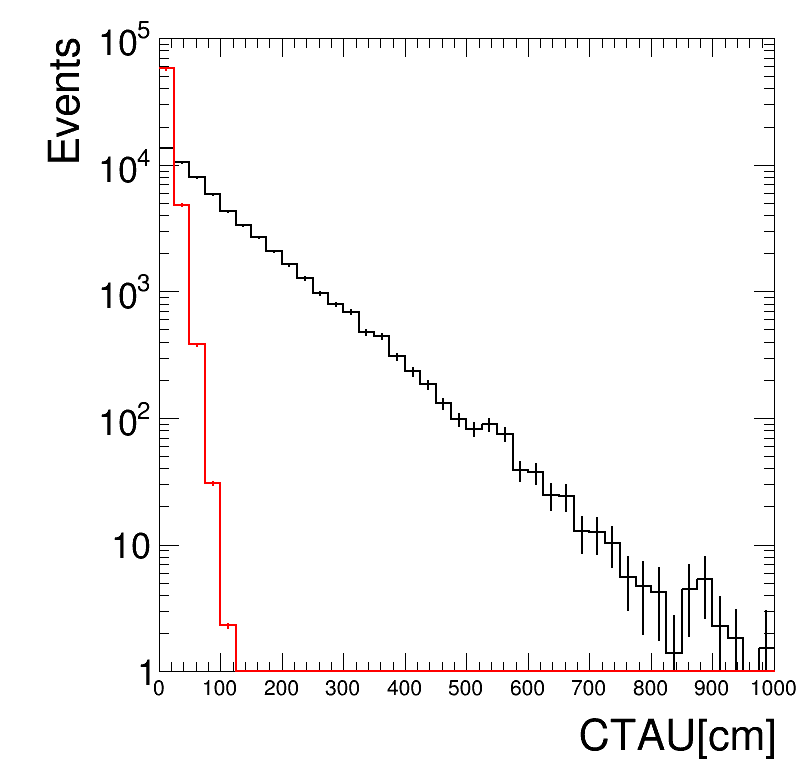

In [34]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
hk = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    #original
    var = trg_jet_ctau[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['CTAU[cm]', 'Events']
    bin_set = [40,0,1000]
    lumi=137000
    
    hk[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    hk[k].SetLineColor(std_color_list[i])
    hk[k].GetXaxis().SetLabelSize(0.03)
    hk[k].GetYaxis().SetRangeUser(1,1e+5)
#     hk[k].Fit('expo')
    print(k, std_color_list[i])
    hk[k].Draw("hist E same") 
    
    i+=1
    #reweight    
    var = trg_jet_ctau[k]
    for ct in ctaus:
        ws = EventReW[k][ct]
        axis_set = ['CTAU[cm]', 'Events']
        bin_set = [40,0,1000]
        lumi=137000

        ht[k] = create_TH1D( var[:,0], axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+7)
#         ht[k].Fit('expo')
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

 
    # leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    outf='CTAU_com.png'
    c.SaveAs(plotDir+outf)    


# add more info about jets

In [271]:
fpath =OrderedDict()
old_ctaus =OrderedDict()
tree = OrderedDict()
# years = ['Summer16', 'Fall17', 'Fall18']
years = [  'Fall17']
# mass = [15, 40, 55]
# mass = [55]
mass = [15]
# OLD_CTAU = np.array([1000, 10000])#in mm
# OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm
# OLD_CTAU = np.array([100])#in mm
# OLD_CTAU = np.array([1000])#in mm
# OLD_CTAU = np.array([10000])#in mm
OLD_CTAU = np.array([100000])#in mm

# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v13/'
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v17/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v15/'

for y in years:
        mc_path = home_dir+'/MC_'+y+'/normalized/'
        tune = 'TuneCP5'
        if y == 'Summer16': tune = 'TuneCUETP8M1'
        for m in mass:
                for ct in OLD_CTAU:
                        key = 'MC_'+y+'_ggH_'+str(m)+'_'+str(ct)      
                        fpath[key] = mc_path+'ggH_HToSSTobbbb_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_' + tune + '_13TeV-powheg-pythia8_1pb_weighted.root'   
                        old_ctaus[key] = ct

In [272]:
NEvents = {}
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['SusyLLPTree']
#     tree[k] = root_dir['SusyLLPSigEffTree']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()

MC_Fall17_ggH_15_100000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v17//MC_Fall17/normalized/ggH_HToSSTobbbb_MH-125_MS-15_ctau-100000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root


In [273]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

ECAL_R=129.0 #cm
EB_Z=268.3 #cm
trg_jet_ctau = {}
trg_jet_eb = {}
trg_jet_tagged = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
#     llp_r = v['gLLP_decay_vertex_r'].array()
#     llp_z = v['gLLP_decay_vertex_z'].array()
    llp_tagged = v['gLLP_tagged'].array()
    llp_eb = v['gLLP_eb'].array()
    llp_ctau = v['gLLP_ctau'].array()
    
#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     if 'H(bb)' in k:
#         met_trg_str = np.logical_and(basic_met_str, np.sum(llp_eb,axis = 1) > 0) 

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    trg_jet_eb[k] = llp_eb[met_trg_str]
    trg_jet_tagged[k] = llp_tagged[met_trg_str]
        

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = trg_jet_puw[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ctau[k] = trg_jet_ctau[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eb[k] = trg_jet_eb[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tagged[k] = trg_jet_tagged[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))
    print(len(trg_jet_pt[k]))
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_eb[k]))
    print(len(trg_jet_tagged[k]))
#     print(trg_jet_ctau[k][:10])
#     print(trg_jet_eb[k][:10])

    

MC_Fall17_ggH_15_100000 <TTree b'SusyLLPTree' at 0x7f80c2a95080>
(28488,)
27441
27441
27441
27441
27441
27441


# Tags

In [274]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

MC_Fall17_ggH_15_100000 <TTree b'SusyLLPTree' at 0x7f80c2a95080>
[[189.09709 160.1638 111.95895] [] [257.31512] ... [] [232.75273 191.84695] [237.29713 45.87461]]
[[] [] [] ... [] [] []]
[[189.09709 160.1638 111.95895] [] [257.31512] ... [] [232.75273 191.84695] [237.29713 45.87461]]
[0 1 2 3 4 5 6 7]
[0 1]
[0 1]


# CTAU plot

In [12]:
variables=[
#      ['jetTime', trg_jet_time, 50, -13, 13],
     ['LLP_ctau_cm', trg_jet_ctau, 50, 0, 1000],
#      ['LLP_ctau_tagged', trg_jet_ctau, 50, 0, 1000],
]

var/x_axis LLP_ctau_cm binning 50 0 1000
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
256
256
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m 1
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
256
256
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m 2
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
274
274
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m 4
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200805/LLP_ctau_cm_bin2.png has been created


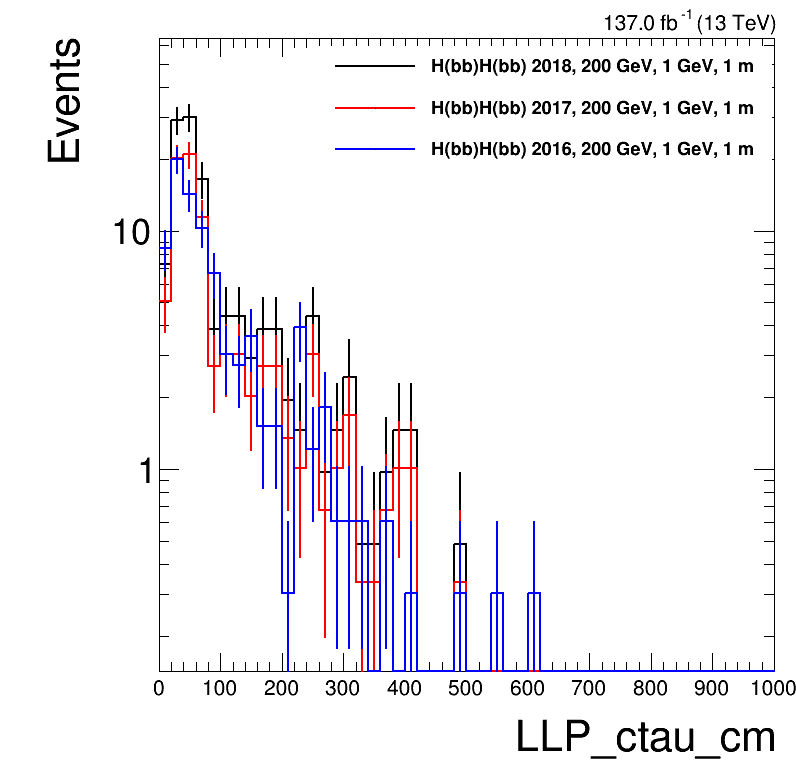

In [13]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    outf=var[0]+'_bin2.png'
#     outf=var[0]+'.png'
    LUMI = 137000 
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    
    color_list = [845,806,861,876,597,625]
    
    i=0
    for k,v in tree.items():
        if '2016' in k:
            lumi=35922
        elif '2017' in k:
            lumi=41529
        elif '2018' in k:
            lumi=59740
        print(k)
        pt1 = var[1][k][nTags[k]==2] 
        v = pt1.flatten()
#         print(v[:10])
#         print(trg_jet_tagged[k][:10])
#         print(trg_jet_ctau[k][:10])
        w = np.array([[x]*len(y) for x,y in zip(trg_jet_w[k][nTags[k]==2],var[1][k][nTags[k]==2] )])
        w = w.flatten()
#         w = trg_jet_w[k] 
        print(w[:10])
        print(len(v))
        print(len(w))
#         w = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set,weights = w*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)

        i+=1

   
    leg.Draw()



    CMS_lumi.lumi_13TeV = str(LUMI/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
#     c.SetLogx()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

In [46]:
trg_tag_ctau = {}
trg_tag_w = {}
ex_nTags = {}
ex_ws = {}

for k,v in tree.items():
    print(k,v)
    
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_w[k]))
    print(len(trg_jet_tagged[k]))
    
    print(trg_jet_ctau[k][:10])
    print(trg_jet_tagged[k][:10])
    
    
    ex_nTags[k] = np.array([[x,x] for x in nTags[k]])
    ex_ws[k] = np.array([[x,x] for x in trg_jet_w[k]])
    print(ex_nTags[k][:10])

    tagged_str = np.logical_and( trg_jet_tagged[k]==True, ex_nTags[k]==2)
    trg_tag_ctau[k]= trg_jet_ctau[k][tagged_str]
    trg_tag_w[k]= ex_ws[k][tagged_str]
    

    print(trg_tag_ctau[k][:10])
    print(trg_tag_w[k][:10])
    
    print(len(trg_tag_ctau[k]))
    print(len(trg_tag_w[k]))
    

H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f9bac6bf240>
3009
3009
3009
[[160.60211     4.173067 ]
 [ 28.563137  221.15602  ]
 [ 62.90738    31.68072  ]
 [ 21.774094  133.86798  ]
 [ 38.919273  251.62563  ]
 [ 99.99705    42.100426 ]
 [ 90.7644    302.83032  ]
 [ 90.77294    10.035434 ]
 [189.34106    12.6600485]
 [129.36894    39.843365 ]]
[[False  True]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False  True]
 [False False]
 [False False]
 [False False]
 [False False]]
[[1 1]
 [0 0]
 [0 0]
 [0 0]
 [2 2]
 [2 2]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[38.919273 42.100426 36.279278 66.69748  33.948143 45.130314 60.16272
 29.388733 38.865467 29.468517]
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
175
175
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f9bac3bf2b0>
3009
3009
3009
[[160.60211     4.173067 ]
 [ 28.563137  221.15602  ]
 [ 62.90738    31.68072 

In [47]:
variables=[
#      ['jetTime', trg_jet_time, 50, -13, 13],
#      ['LLP_ctau_cm', trg_jet_ctau, 50, 0, 1000],
     ['LLP_ctau_tagged', trg_tag_ctau, 50, 0, 1000],
]

var/x_axis LLP_ctau_tagged binning 50 0 1000
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
[38.919273 42.100426 36.279278 66.69748  33.948143 45.130314 60.16272
 29.388733 38.865467 29.468517]
175
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
175
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m 1
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
[38.919273 42.100426 36.279278 66.69748  33.948143 45.130314 60.16272
 29.388733 38.865467 29.468517]
175
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
175
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m 2
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m
[19.48241  40.11318  41.516476 59.17166  76.73961  68.69082  53.418297
 42.219376 61.238895 46.78165 ]
198
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
198
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m 4
137.0 f

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200805/LLP_ctau_tagged_bin2.png has been created


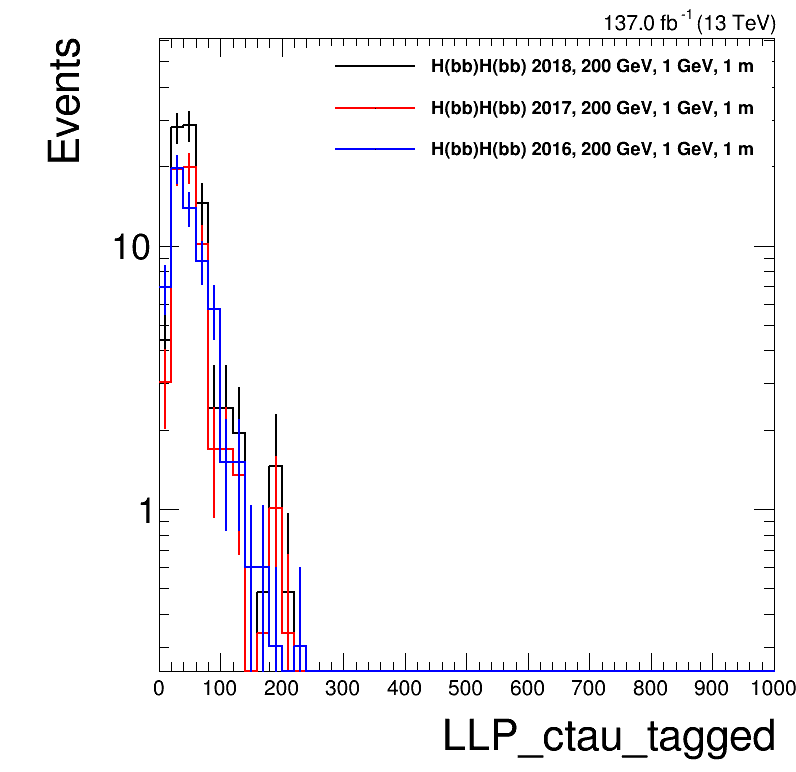

In [49]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    outf=var[0]+'_bin2.png'
#     outf=var[0]+'.png'
    LUMI = 137000 
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    
    color_list = [845,806,861,876,597,625]
    
    i=0
    for k,v in tree.items():
        if '2016' in k:
            lumi=35922
        elif '2017' in k:
            lumi=41529
        elif '2018' in k:
            lumi=59740
        print(k)
        pt1 =  var[1][k] 
#         v = pt1.flatten()
        v = pt1 
        print(v[:10])
        w =  trg_tag_w[k] 
#         w = w.flatten()
        print(len(v))
#         w = trg_jet_w[k] 
        print(w[:10])
        print(len(w))
#         w = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set, weights=w*lumi )
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)

        i+=1

   
    leg.Draw()



    CMS_lumi.lumi_13TeV = str(LUMI/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
#     c.SetLogx()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

In [50]:
trg_untag_ctau = {}
trg_untag_w = {}
# ex_nTags = {}
# ex_ws = {}

for k,v in tree.items():
    print(k,v)
    
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_w[k]))
    print(len(trg_jet_tagged[k]))
    
    print(trg_jet_ctau[k][:10])
    print(trg_jet_tagged[k][:10])
    
    
#     ex_nTags[k] = np.array([[x,x] for x in nTags[k]])
#     ex_ws[k] = np.array([[x,x] for x in trg_jet_w[k]])
#     print(ex_nTags[k][:10])

    untagged_str = np.logical_and( trg_jet_tagged[k]==False, ex_nTags[k]==2)
    trg_untag_ctau[k]= trg_jet_ctau[k][untagged_str]
    trg_untag_w[k]= ex_ws[k][untagged_str]
    

    print(trg_untag_ctau[k][:10])
    print(trg_untag_w[k][:10])
    
    print(len(trg_untag_ctau[k]))
    print(len(trg_untag_w[k]))
    

H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f9bac6bf240>
3009
3009
3009
[[160.60211     4.173067 ]
 [ 28.563137  221.15602  ]
 [ 62.90738    31.68072  ]
 [ 21.774094  133.86798  ]
 [ 38.919273  251.62563  ]
 [ 99.99705    42.100426 ]
 [ 90.7644    302.83032  ]
 [ 90.77294    10.035434 ]
 [189.34106    12.6600485]
 [129.36894    39.843365 ]]
[[False  True]
 [False False]
 [False False]
 [False False]
 [ True False]
 [False  True]
 [False False]
 [False False]
 [False False]
 [False False]]
[251.62563  99.99705  79.28901 163.20549 166.56381 151.16922  77.16875
  74.76204 139.3101  209.6225 ]
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
81
81
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f9bac3bf2b0>
3009
3009
3009
[[160.60211     4.173067 ]
 [ 28.563137  221.15602  ]
 [ 62.90738    31.68072  ]
 [ 21.774094  133.86798  ]
 [ 38.919273  251.62563  ]
 [ 99.99705    

In [52]:
variables=[
     ['LLP_ctau_untagged', trg_untag_ctau, 50, 0, 1000],
]

var/x_axis LLP_ctau_untagged binning 50 0 1000
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m
[251.62563  99.99705  79.28901 163.20549 166.56381 151.16922  77.16875
  74.76204 139.3101  209.6225 ]
81
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
81
H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m 1
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m
[251.62563  99.99705  79.28901 163.20549 166.56381 151.16922  77.16875
  74.76204 139.3101  209.6225 ]
81
[8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06
 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06 8.116029e-06]
81
H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m 2
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m
[106.2473   210.62949  360.291    235.78244  487.93176  159.86177
  87.771065 332.24683  282.74857  291.87674 ]
76
[8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06
 8.41607e-06 8.41607e-06 8.41607e-06 8.41607e-06]
76
H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m 4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200805/LLP_ctau_untagged_bin2.png has been created


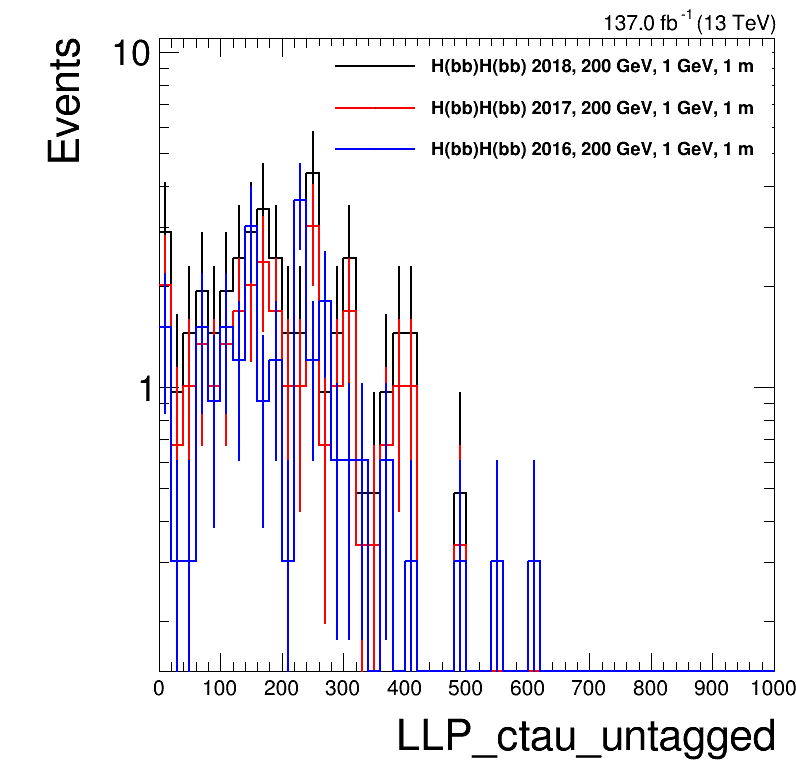

In [53]:
for var in variables:
    print('var/x_axis', var[0], 'binning', var[2], var[3], var[4])
    x_axis = var[0]
    y_axis = 'Events'
    axis_set = [x_axis, y_axis]
    bin_set = [var[2],var[3],var[4]]
    outf=var[0]+'_bin2.png'
#     outf=var[0]+'.png'
    LUMI = 137000 
    
    # Plotting  
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.40,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    
    color_list = [845,806,861,876,597,625]
    
    i=0
    for k,v in tree.items():
        if '2016' in k:
            lumi=35922
        elif '2017' in k:
            lumi=41529
        elif '2018' in k:
            lumi=59740
        print(k)
        pt1 =  var[1][k] 
#         v = pt1.flatten()
        v = pt1 
        print(v[:10])
        w =  trg_untag_w[k] 
#         w = w.flatten()
        print(len(v))
#         w = trg_jet_w[k] 
        print(w[:10])
        print(len(w))
#         w = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])] 

        ht[k] = create_TH1D( v, axis_title=axis_set, name=k, binning=bin_set, weights=w*lumi )
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        print(k, std_color_list[i])
        ht[k].Draw("hist E same")
        leg.AddEntry(ht[k],k)

        i+=1

   
    leg.Draw()



    CMS_lumi.lumi_13TeV = str(LUMI/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)


    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
#     c.SetLogx()
    c.Draw()
    c.SaveAs(plotDir+outf)
 

# Signal Yields

In [275]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , ' Yield', ' Error'])
for k,v in tree.items():
#     print(k)
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    EventWsq = [x*x for x in EventW]
#     print(np.sum(EventW)*lumi)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------------+---------+--------+
|          Sample         |      Weight     |   Yield |  Error |
+-------------------------+-----------------+---------+--------+
| MC_Fall17_ggH_15_100000 | [1.1667261e-06] | 4570.22 | 29.44  |
+-------------------------+-----------------+---------+--------+


In [276]:
table_txt = table.get_string()
with open(plotDir+'/Jets_alltag_100m_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10cm_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1m_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10m_SignalSummaryTable.txt','w') as file:
    file.write(table_txt)

In [277]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 0 Yield', 'Bin 0 Error'])
for k,v in tree.items():
#     print(k)
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==0],trg_jet_puw[k][nTags[k]==0])]
    EventWsq = [x*x for x in EventW]
#     print(np.sum(EventW)*lumi)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------------+-------------+-------------+
|          Sample         |      Weight     | Bin 0 Yield | Bin 0 Error |
+-------------------------+-----------------+-------------+-------------+
| MC_Fall17_ggH_15_100000 | [1.1667261e-06] |   4567.02   |    29.43    |
+-------------------------+-----------------+-------------+-------------+


In [278]:
table_txt = table.get_string()
with open(plotDir+'/Jets_alltag_100m_SignalSummaryTableBin0.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10cm_SignalSummaryTableBin0.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1m_SignalSummaryTableBin0.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10m_SignalSummaryTableBin0.txt','w') as file:
    file.write(table_txt)

In [279]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 1 Yield', 'Bin 1 Error'])
for k,v in tree.items():
#     print(k)
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==1],trg_jet_puw[k][nTags[k]==1])]
    EventWsq = [x*x for x in EventW]
#     print(np.sum(EventW)*lumi)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------------+-------------+-------------+
|          Sample         |      Weight     | Bin 1 Yield | Bin 1 Error |
+-------------------------+-----------------+-------------+-------------+
| MC_Fall17_ggH_15_100000 | [1.1667261e-06] |     3.2     |     0.78    |
+-------------------------+-----------------+-------------+-------------+


In [280]:
table_txt = table.get_string()
with open(plotDir+'/Jets_alltag_100m_SignalSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10cm_SignalSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1m_SignalSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10m_SignalSummaryTableBin1.txt','w') as file:
    file.write(table_txt)

In [281]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
#     print(k)
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
    EventWsq = [x*x for x in EventW]
#     print(np.sum(EventW)*lumi)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------------+-------------+-------------+
|          Sample         |      Weight     | Bin 2 Yield | Bin 2 Error |
+-------------------------+-----------------+-------------+-------------+
| MC_Fall17_ggH_15_100000 | [1.1667261e-06] |     0.0     |     0.0     |
+-------------------------+-----------------+-------------+-------------+


In [282]:
table_txt = table.get_string()
with open(plotDir+'/Jets_alltag_100m_SignalSummaryTableBin2.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10cm_SignalSummaryTableBin2.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1m_SignalSummaryTableBin2.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10m_SignalSummaryTableBin2.txt','w') as file:
    file.write(table_txt)

# Reweight CTAU

In [208]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight


In [75]:
print(trg_jet_ctau[k][0])


[1579.4193  920.481 ]


In [76]:
# for k,v in tree.items():
#     print(k)    
#     print(old_ctaus[k])

In [283]:
#weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau[k]/10) # convert everything to cm
# OLD_CTAU=1000 #mm
# OLD_CTAU=10000 #mm
OLD_CTAU=100000 #mm
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([10000])
# ctaus=np.array([1000, 10000])
# ctaus=np.array([1000])
# ctaus=np.array([100])
ctaus=np.array([100, 1000, 10000, 100000])
EventReW = {}
EventReWsq = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    EventReWsq[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
#         weight_ctau = weight_calc(trg_jet_ctau[k][nTags[k]==2], float(ct)/10, old_ctaus[k]/10) # convert everything to cm
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k] ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] = [x*y for x,y in zip(EventW,weight_ctau)]
        EventReWsq[k][ct] = [x*x for x in EventReW[k][ct]]
        
#         print(len(EventW))
#         print(len(weight_ctau))
#         print(len(EventReW[k][ct]))


MC_Fall17_ggH_15_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


In [284]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', ' Yield', ' Error'])
for k,v in tree.items():
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReWsq[k][ct]))*lumi, 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------+---------+--------+
|          Sample         | Ctau [mm] |   Yield |  Error |
+-------------------------+-----------+---------+--------+
| MC_Fall17_ggH_15_100000 |    100    |   1.95  |  1.59  |
| MC_Fall17_ggH_15_100000 |    1000   | 2732.79 | 991.22 |
| MC_Fall17_ggH_15_100000 |   10000   | 4284.08 | 146.19 |
| MC_Fall17_ggH_15_100000 |   100000  | 4570.22 | 29.44  |
+-------------------------+-----------+---------+--------+


In [285]:
table_txt = table.get_string()
# with open(plotDir+'/CTAU_from1m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/CTAU_from10m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10m_alltags_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10cm_alltags_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo1m_alltags_SignalSummaryTable.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo_alltags_SignalSummaryTable.txt','w') as file:
with open(plotDir+'/Jets_alltag_100mTo_alltags_SignalSummaryTable.txt','w') as file:
    file.write(table_txt)

In [286]:
#weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau[k]/10) # convert everything to cm
# OLD_CTAU=1000 #mm
# OLD_CTAU=10000 #mm
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([10000])
# ctaus=np.array([1000, 10000])
# ctaus=np.array([1000])
EventReW = {}
EventReWsq = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    EventReWsq[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==0],trg_jet_puw[k][nTags[k]==0])]
#         weight_ctau = weight_calc(trg_jet_ctau[k][nTags[k]==2], float(ct)/10, old_ctaus[k]/10) # convert everything to cm
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k][nTags[k]==0] ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] = [x*y for x,y in zip(EventW,weight_ctau)]
        EventReWsq[k][ct] = [x*x for x in EventReW[k][ct]]
#         print(len(EventW))
#         print(len(weight_ctau))
#         print(len(EventReW[k][ct]))


MC_Fall17_ggH_15_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


In [287]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', 'Bin 0 Yield', 'Bin 0 Error'])
for k,v in tree.items():
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReWsq[k][ct]))*lumi, 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------+-------------+-------------+
|          Sample         | Ctau [mm] | Bin 0 Yield | Bin 0 Error |
+-------------------------+-----------+-------------+-------------+
| MC_Fall17_ggH_15_100000 |    100    |     1.95    |     1.59    |
| MC_Fall17_ggH_15_100000 |    1000   |   2732.79   |    991.22   |
| MC_Fall17_ggH_15_100000 |   10000   |   4282.14   |    146.18   |
| MC_Fall17_ggH_15_100000 |   100000  |   4567.02   |    29.43    |
+-------------------------+-----------+-------------+-------------+


In [288]:
table_txt = table.get_string()
# with open(plotDir+'/CTAU_from1m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/CTAU_from10m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10m_SignalSummaryTableBin0.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo1m_SignalSummaryTableBin0.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo_SignalSummaryTableBin0.txt','w') as file:
with open(plotDir+'/Jets_alltag_100mTo_SignalSummaryTableBin0.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10cm_SignalSummaryTableBin0.txt','w') as file:
    file.write(table_txt)

In [289]:
#weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau[k]/10) # convert everything to cm
# OLD_CTAU=1000 #mm
# OLD_CTAU=10000 #mm
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([10000])
# ctaus=np.array([1000, 10000])
# ctaus=np.array([1000])
EventReW = {}
EventReWsq = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    EventReWsq[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==1],trg_jet_puw[k][nTags[k]==1])]
#         weight_ctau = weight_calc(trg_jet_ctau[k][nTags[k]==2], float(ct)/10, old_ctaus[k]/10) # convert everything to cm
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k][nTags[k]==1] ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] = [x*y for x,y in zip(EventW,weight_ctau)]
        EventReWsq[k][ct] = [x*x for x in EventReW[k][ct]]
#         print(len(EventW))
#         print(len(weight_ctau))
#         print(len(EventReW[k][ct]))


MC_Fall17_ggH_15_100000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


In [290]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', 'Bin 1 Yield', 'Bin 1 Error'])
for k,v in tree.items():
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReWsq[k][ct]))*lumi, 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+-------------------------+-----------+-------------+-------------+
|          Sample         | Ctau [mm] | Bin 1 Yield | Bin 1 Error |
+-------------------------+-----------+-------------+-------------+
| MC_Fall17_ggH_15_100000 |    100    |     0.0     |     0.0     |
| MC_Fall17_ggH_15_100000 |    1000   |     0.0     |     0.0     |
| MC_Fall17_ggH_15_100000 |   10000   |     1.95    |     1.54    |
| MC_Fall17_ggH_15_100000 |   100000  |     3.2     |     0.78    |
+-------------------------+-----------+-------------+-------------+


In [291]:
table_txt = table.get_string()
# with open(plotDir+'/CTAU_from1m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/CTAU_from10m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10m_SignalSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo1m_SignalSummaryTableBin1.txt','w') as file:
with open(plotDir+'/Jets_alltag_100mTo_SignalSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo_SignalSummaryTableBin1.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10cm_SignalSummaryTableBin1.txt','w') as file:
    file.write(table_txt)

In [256]:
#weight_ctau = weight_calc(gLLP_ctau, float(ct)/10, old_ctau[k]/10) # convert everything to cm
# OLD_CTAU=1000 #mm
# OLD_CTAU=10000 #mm
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([10000])
# ctaus=np.array([1000, 10000])
# ctaus=np.array([1000])
EventReW = {}
EventReWsq = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    EventReWsq[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
#         weight_ctau = weight_calc(trg_jet_ctau[k][nTags[k]==2], float(ct)/10, old_ctaus[k]/10) # convert everything to cm
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k][nTags[k]==2] ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] = [x*y for x,y in zip(EventW,weight_ctau)]
        EventReWsq[k][ct] = [x*x for x in EventReW[k][ct]]
#         print(len(EventW))
#         print(len(weight_ctau))
#         print(len(EventReW[k][ct]))


MC_Fall17_ggH_15_10000
ctau 100  mm
ctau 1000  mm
ctau 10000  mm
ctau 100000  mm


In [257]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
#     if 'Summer16' in k:
#         lumi=35922
#     elif 'Fall17' in k:
#         lumi=41529
#     elif 'Fall18' in k:
#         lumi=59740
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReWsq[k][ct]))*lumi, 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+------------------------+-----------+-------------+-------------+
|         Sample         | Ctau [mm] | Bin 2 Yield | Bin 2 Error |
+------------------------+-----------+-------------+-------------+
| MC_Fall17_ggH_15_10000 |    100    |     0.0     |     0.0     |
| MC_Fall17_ggH_15_10000 |    1000   |     0.0     |     0.0     |
| MC_Fall17_ggH_15_10000 |   10000   |     0.0     |     0.0     |
| MC_Fall17_ggH_15_10000 |   100000  |     0.0     |     0.0     |
+------------------------+-----------+-------------+-------------+


In [258]:
table_txt = table.get_string()
# with open(plotDir+'/CTAU_from1m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/CTAU_from10m_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10m_SignalSummaryTableBin2.txt','w') as file:
# with open(plotDir+'/Jets_alltag_10mTo1m_SignalSummaryTableBin2.txt','w') as file:
with open(plotDir+'/Jets_alltag_10mTo_SignalSummaryTableBin2.txt','w') as file:
# with open(plotDir+'/Jets_alltag_1mTo10cm_SignalSummaryTableBin2.txt','w') as file:
    file.write(table_txt)